In [102]:
#import statements
import pandas as pd
from bs4 import BeautifulSoup
import urllib3
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib
%matplotlib inline
pd.options.mode.chained_assignment = None

Motivation for Performing The Analysis
=====================================
I'm looking to analyze the Android market determine what are the most popular types of apps,
looking at the different categories of apps and how they rank,
and what applications and types are users rating the highest. How do we determine the most popular application as based on the website from the Google store data.
#### Main Data Source:
[Kaggle - Google Play Store Apps](#https://www.kaggle.com/lava18/google-play-store-apps)
Data has been included in this Github Repository for reference.
Data is read in and tidied in this section.
<strong>Data transformation operations</strong>

In [103]:
googlereviews = pd.read_csv('googleplaystore.csv')
googlesent = pd.read_csv('googleplaystore_user_reviews.csv')

#Tidying data, drop empty values
googlereviews.dropna(inplace=True)
googlesent.dropna(inplace=True)

#Tidying data, drop unneeded columns, convert columns to INT
googlereviews.drop(columns=['Android Ver', 'Current Ver', 'Size'])
googlereviews['Installs'] = googlereviews['Installs'].str.replace('+', '')
googlereviews['Installs'] = googlereviews['Installs'].str.replace(",","")
googlereviews['Installs'] = pd.to_numeric(googlereviews['Installs'])
googlereviews['Rating'] = pd.to_numeric(googlereviews['Rating'])
googlereviews['Reviews'] = pd.to_numeric(googlereviews['Reviews'])

Here is the data after it has been tidied up

In [104]:
googlesent.head()


,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.00,0.533333
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462
3,10 Best Foods for You,Works great especially going grocery store,Positive,0.40,0.875000
4,10 Best Foods for You,Best idea us,Positive,1.00,0.300000
5,10 Best Foods for You,Best way,Positive,1.00,0.300000


In [105]:
googlereviews.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,10000,Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,500000,Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,5000000,Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,50000000,Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,100000,Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


#### Web Scraping Data Source, second data source
The data was obtained from this website [App Annie](https://www.appannie.com/en/apps/google-play/top/)
Here the data is web scrapped, we find the elements that contain the table we are looking for.

In [106]:
http = urllib3.PoolManager()
response = http.request('GET',
                            'https://www.appannie.com/en/apps/google-play/top/')
soup = BeautifulSoup(response.data)
table = soup.find_all('div', attrs={'class': 'textContainer_ssmtv3'})

###### Cleaning the data
The data that is scrapped from the web, there are three tables on the web page. Table for paid, grossing and free.
The data is stripped down, and tidied up to only find the table with the applications names, ranking and type.
Additional tiding up and <strong>Aggregation</strong>

In [107]:
rank=1
ranked = []
track = 0
for rows in table:
    appname = rows.find('p', attrs={'class': 'n_1jv8115-o_O-Content_1xn1r0f-o_O-c0f2346_4s8r2l-o_O-text_7y41qf-o_O-item_9xo99e'}).get_text().strip()
    appname
    if track < 50:
        type = 'free'
    elif track < 100:
        type = 'paid'
    else:
        type = 'grossing'

    ranked.append([rank, appname, type])
    if rank ==50 or rank == 100:
        rank = 0
    rank += 1
    track += 1

rankeddf = pd.DataFrame(ranked, columns=["ranking", "name", "type"])
rankeddf.dropna(inplace=True)

Here is the data after tiding up

In [108]:
rankeddf.head()

,ranking,name,type
0,1,Crypto.com - Buy Bitcoin Now,free
1,2,GasBuddy: Find and Pay for Cheap Gas and Fuel,free
2,3,Catwalk Beauty,free
3,4,Coinbase – Buy & Sell Bitcoin. Crypto Wallet,free
4,5,Slice It All!,free


### Statistical Analysis and Graphics
Find the average rating of an application, grouping by category, and determining what are the top-rated categories.

In [109]:
avg_ratinghighest = googlereviews.groupby('Category')['Rating'].mean().sort_values(ascending=False)
avg_rating = googlereviews.groupby('Category')['Rating'].mean()
avg_ratinghighest.head()

Category
EVENTS                 4.435556
EDUCATION              4.389032
ART_AND_DESIGN         4.377049
BOOKS_AND_REFERENCE    4.346067
PERSONALIZATION        4.335256
Name: Rating, dtype: float64

The tope rated gategories are Events, education, Art & Design.
Graphics Showing the spread of the ratings:

<AxesSubplot:xlabel='Category', ylabel='Rating'>

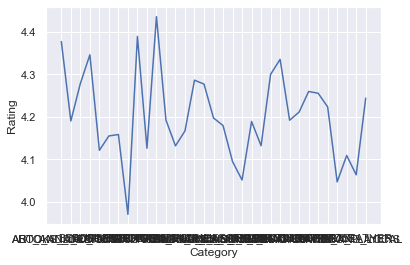

In [110]:
sns.set_theme(style="darkgrid")
sns.lineplot(data=avg_rating)

Find the sentiment for the applications, grouping by the name and sentime, which can be negative, neutral or postivie.

In [111]:
googlesentcount = googlesent.groupby(['App', 'Sentiment']).count().reset_index()
googlesentcount.drop(columns=(['Sentiment_Polarity', 'Sentiment_Subjectivity']), inplace=True)
googlesentcount.rename(columns={'Translated_Review':'Count'}, inplace=True)
googlesentcount.head()

,App,Sentiment,Count
0,10 Best Foods for You,Negative,10
1,10 Best Foods for You,Neutral,22
2,10 Best Foods for You,Positive,162
3,104 找工作 - 找工作 找打工 找兼職 履歷健檢 履歷診療室,Negative,1
4,104 找工作 - 找工作 找打工 找兼職 履歷健檢 履歷診療室,Neutral,8


Here we are going to find what applications had the highest number of positive reviews, based on the sentiment analysis data.


In [112]:
gspositive = googlesentcount[googlesentcount['Sentiment'] == 'Positive']
toppos = gspositive.sort_values(by=['Count'], inplace=True, ascending=False)
toppos = gspositive.head()
toppos


,App,Sentiment,Count
2248,Helix Jump,Positive,209
1395,Duolingo: Learn Languages Free,Positive,200
899,Calorie Counter - Macros,Positive,174
902,Calorie Counter - MyFitnessPal,Positive,169
718,Bowmasters,Positive,169


We find that Helix Jump is the most positively reviewed Application, and the other top 5 applications in this category.

Text(0.5, 0.98, 'Most Positively Reviewed Applications')

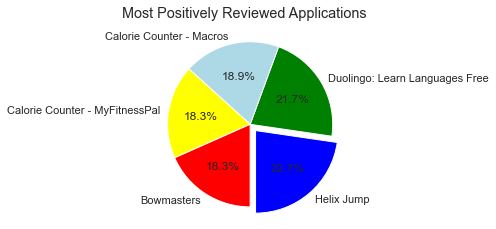

In [113]:
data = np.array([5,3,4,6])
labels = toppos['App']
colrs=['blue', 'green', 'lightblue', 'yellow', 'red']
explode = (0.1, 0, 0, 0, 0)
# --- the plot
fig, ax = plt.subplots(figsize=(8, 3.5))
ax.pie(toppos['Count'], explode=explode,
 labels=labels, autopct='%1.1f%%',
 startangle=270, colors=colrs)
ax.axis('equal') # keep it a circle
# --- tidy-up and save
fig.suptitle("Most Positively Reviewed Applications")

We find that Fashion in Vogue is the most neutrally reviewed Application, and the other top 5 applications in this category.

In [114]:
gsneutral = googlesentcount[googlesentcount['Sentiment'] == 'Neutral']
topnet = gsneutral.sort_values(by=['Count'], inplace=True, ascending=False)
topnet = gsneutral.head()
topnet



,App,Sentiment,Count
714,Booking.com Travel Deals,Neutral,39
452,BET NOW - Watch Shows,Neutral,39
623,"BestCam Selfie-selfie, beauty camera, photo ed...",Neutral,39
2072,Google My Business,Neutral,39
1635,Fashion in Vogue,Neutral,35


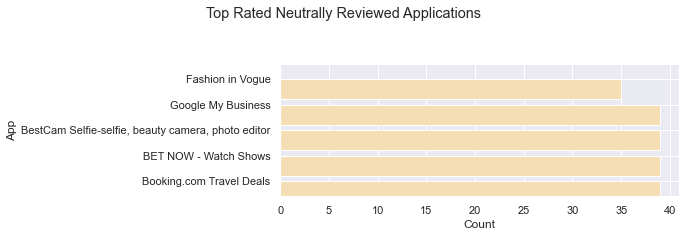

In [115]:
labels = topnet['App']
data = topnet['Count']
width = 0.8
yTickPos = np.arange(len(data))
yBarPos = yTickPos - (width/2.0)
fig, ax = plt.subplots(figsize=(10, 3.5))
ax.barh(yBarPos,data,width,color='wheat')
ax.set_yticks(ticks= yTickPos)
ax.set_yticklabels(labels)
ax.set_ylim((min(yTickPos)-0.6,
 max(yTickPos)+0.6))
ax.xaxis.grid(True)
ax.set_ylabel('App');
ax.set_xlabel('Count')
fig.suptitle("Top Rated Neutrally Reviewed Applications")
fig.tight_layout(pad=2)


We find that Angry Birds Classic is the most negatively reviewed Application, and the other top 5 applications in this category.

In [116]:
gsnegative = googlesentcount[googlesentcount['Sentiment'] == 'Negative']
topneg = gsnegative.sort_values(by=['Count'], inplace=True, ascending=False)
topneg = gsnegative.head()
topneg

,App,Sentiment,Count
311,Angry Birds Classic,Negative,147
917,Candy Crush Saga,Negative,126
716,Bowmasters,Negative,119
56,8 Ball Pool,Negative,106
920,Candy Crush Soda Saga,Negative,96


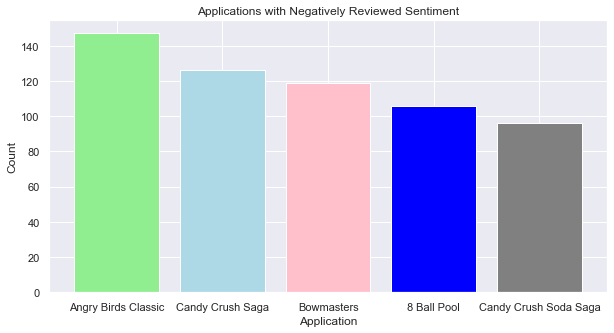

In [117]:
f, ax = plt.subplots(figsize=(10,5))
colors = ['lightgreen', 'lightblue', 'pink', 'blue', 'grey']
plt.bar(topneg['App'],topneg['Count'], color=colors)
plt.title('Applications with Negatively Reviewed Sentiment')
plt.xlabel('Application')
plt.ylabel('Count')
plt.show()


The current top grossing applications


In [118]:
rankgross = rankeddf[rankeddf['type'] == 'grossing']
rankgrosstop = rankgross.head()
rankgrosstop


,ranking,name,type
100,1,Garena Free Fire- World Series,grossing
101,2,Google One,grossing
102,3,Coin Master,grossing
103,4,Candy Crush Saga,grossing
104,5,Roblox,grossing


The current top paid applications


In [119]:
rankpaid = rankeddf[rankeddf['type'] == 'paid']
rankpaidtop = rankpaid.head()
rankpaidtop


,ranking,name,type
50,1,Minecraft,paid
51,2,Bloons TD 6,paid
52,3,Geometry Dash,paid
53,4,Monopoly - Board game classic about real-estate!,paid
54,5,HotSchedules,paid


The current top free applications:


In [120]:
rankfree = rankeddf[rankeddf['type'] == 'free']
rankfreetop = rankfree.head()
rankfreetop

,ranking,name,type
0,1,Crypto.com - Buy Bitcoin Now,free
1,2,GasBuddy: Find and Pay for Cheap Gas and Fuel,free
2,3,Catwalk Beauty,free
3,4,Coinbase – Buy & Sell Bitcoin. Crypto Wallet,free
4,5,Slice It All!,free


Find the Applications with the most installs, since there are so many installs that are over 1 million, data will be grouped by category.


In [121]:
googlereviews.sort_values(by=['Installs'], inplace=True, ascending=False)
googlemostinstall = googlereviews.groupby(['Category'])['Installs'].count().reset_index()
googlemostinstall.sort_values(by=['Installs'], ascending=False, inplace=True)
googlemostinstall.head()


,Category,Installs
11,FAMILY,1746
14,GAME,1097
29,TOOLS,733
25,PRODUCTIVITY,351
20,MEDICAL,350


##### Conclusion
- Candy Crush Saga had the highest number of negative reviews, it is one of the top grossing applications. We cannot use the sentiment analysis to determine if an application will be the most popular.
- The Type of games that have the highest number of reviews are Events, Education, Art& Design, Books & Reference and Personalization. The top paid, free and grossing applications would fall into a Game category, we cannot use the average reviewing rating to determine if the type of game that has a high review will be a top downloaded game. Though we do see that Duo Lingo, an Education application, had some of the most positive sentiment reviews.
- The other applications though with positive sentiment reviews were Fitness and Games. Using the average application rating, the sentiment analysis does not determine if a game will be a top downloaded, most popular game, we cannot use this information for correlation as previously hoped.
- Looking at which applications had the most installs the top five were Family, Game, Tools, Productivity and Medical. The top ranking grossing, paid and free games all have fallen into these categories. We are able to use the number of installs to find the top ranking applications.

##### One Feature that was not covered in Class
The feature that I used that was not covered in class was I created my Slide Desk directly from Juypter Notebook.